In [2]:
import numpy as np #Numpy is useful for calculations
import matplotlib.pyplot as plt #Matplotlib gives us access to plotting tools for showing our results

In [3]:
G = 6.674 * 10**(-11) #Gravitational constant
M = 5.972 * 10**24 #Mass of the Earth
R_Earth = 6.371 * 10**6 #Radius of the Earth

#This function takes your current height above the ground and returns your current acceleration due to anti-gravity
def antiGravAccel(h):
    return G * M / (R_Earth + h)**2
#Note that this function returns a positive acceleration, which will increase your speed in the upward direction
#If you were to add a minus sign here, you would have a function for normal gravity instead, pushing you down
#You should try reversing gravity again and starting the fall up in the air to see how a "normal fall" would be

## Air Resistance

In [4]:
def drag(rho, v, Cd, A):
    return -0.5 * rho * v * abs(v) * Cd * A
#The minus sign and the v * abs(v) here insures that drag will work in the direction opposite of the one you're moving

In [5]:
def USStdAtmos(Z): #Input is height in meters
    r0 = 6356.766 #The Radius of the Earth in km
    Z = Z / 1000  #Conversion from m to km
    H = r0 * Z / (r0 + Z) #Conversion to geopotential height. Can be thought of as gravity-adjusted height
    if H < 11:
        Hb = 0                #The starting height for this section in geopotential km
        Tb = 288.15           #The starting temperature in kelvin
        L = -6.5              #The temperature change in kelvin per geopotential km
        Pb = 1.01325 * 10**3  #The starting pressure in millibars
    elif H < 20:
        Hb = 11
        Tb = 216.65
        L = 0
        Pb = 2.2632 * 10**2
    elif H < 32:
        Hb = 20
        Tb = 216.65
        L = 1
        Pb = 5.4748 * 10**1
    elif H < 47:
        Hb = 32
        Tb = 228.65
        L = 2.8
        Pb = 8.6801
    elif H < 51:
        Hb = 47
        Tb = 270.65
        L = 0
        Pb = 1.1090
    elif H < 71:
        Hb = 51
        Tb = 270.65
        L = -2.8
        Pb = 6.6938 * 10**(-1)
    elif H < 84.8520: #84.8520 geopotential kilometres is the same as 86 normal kilometres
        Hb = 71
        Tb = 214.65
        L = -2
        Pb = 3.9564 * 10**(-2)
        
    if H < 84.8520:
        T = Tb + L * (H - Hb) #Temperature formula for the lower half of the model
        
        g0s = 9.80665 #m^2/(s^2*m')
        Rs = 8.31432 * 10**(3) #Nm/(kmol*K)
        M0 = 28.9644 #kg/kmol
        if L == 0: #There is a different formula for pressure depending on if the temperature is changing or not
            P = Pb * np.exp((-g0s * M0 * 1000 * (H - Hb))/(Rs * Tb)) #Multiplying by 1000 for unit conversion
        else:
            P = Pb * ((Tb) / (Tb + L * (H - Hb)))**((g0s * M0 * 1000) / (Rs * L)) #Pressure is given in millibars

        rho = P * M0 / (Rs * T) * 100 #Density in kg/m^3
    else:
        T, P, rho = 187, 0, 0 #For heights 86km and up we need a different formula for finding pressure.
                              #For our purposes 0 will do. Ways of finding pressure above 86km are given, but they are
                              #harder to implement, and were therefore not. We also do not bother finding
                              #the temperature above 86km as it is of no use on its own in this essay.
    return T, P, rho  #We only need density(rho), but temperature and pressure are also interesting to look at

We only really need the density, but the function also returns temperature and pressure so that we can plot them together and see how they relate.

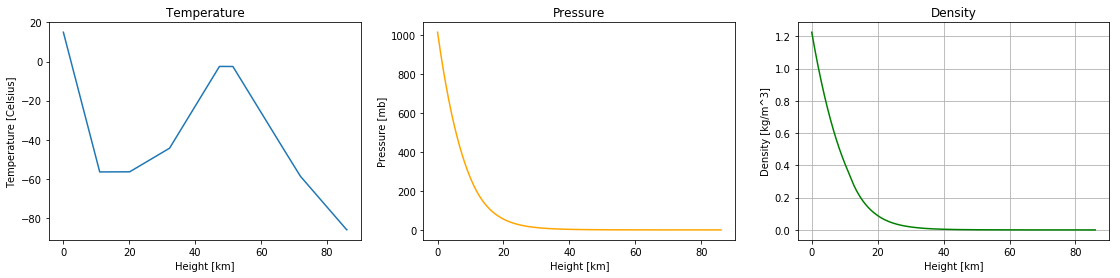

In [6]:
heights = np.linspace(0,86,10000)
results = [USStdAtmos(Z*1000) for Z in heights]
T = [res[0]-273.15 for res in results]
P = [res[1] for res in results]
rho = [res[2] for res in results]

plt.figure(figsize=(19,4))
plt.subplot(131)
plt.plot(heights, T)
plt.xlabel("Height [km]")
plt.ylabel("Temperature [Celsius]")
plt.title("Temperature")

plt.subplot(132)
plt.plot(heights, P, color="orange")
plt.xlabel("Height [km]")
plt.ylabel("Pressure [mb]")
plt.title("Pressure")

plt.subplot(133)
plt.plot(heights, rho, color="green")
plt.xlabel("Height [km]")
plt.ylabel("Density [kg/m^3]")
plt.title("Density")
plt.grid()

plt.show()

## Calculating the movement of a fall into space

In [7]:
def acceleration(height, velocity, Cd, A, m):
    density = USStdAtmos(height)[2] #Note that the USStdAtmos fuction returns density as its third return value, hence the [2]
    airRes = drag(density, velocity, Cd, A)
    return airRes/m - antiGravAccel(height)

From here we need to define our initial conditions. We'll use the drag coefficient of 0,7 and cross sectional area of 0.18m^2 for a head first fall. We will also assume you have a mass of 80kg, and that you start on the ground with no initial velocity.

In [29]:
#These values gives us a good look at a fall from 0 to 100km
n = 20000  #The number of steps in the Euler-Cromer calculation
dt = 0.013 #The size of each time-step in the Euler-Cromer calculation

pos = np.zeros(n) #Height in meters
vel = np.zeros(n) #Velocity in m/s
acc = np.zeros(n) #Acceleration in m/s^2

#We will also keep track of these values for the analysis
drg = np.zeros(n)   #Drag
velsq = np.zeros(n) #Velocity squared
dns = np.zeros(n)   #Air density
grv = np.zeros(n)   #Anti-gravity

time = np.linspace(0, n*dt, n)

pos[0] = 41419 #These values were already 0, but feel free to change them and see what happens
vel[0] = 0

Cd = 0.7 #Drag coefficient (0.7 for a head first fall)
A = 1 #Cross sectional area (1.0 for a head first fall)
m = 80   #Mass

Feel free to change the mass, drag coefficient or cross-sectional area to see how the results would change. A different starting position and velocity could also lead to some interesting results.

We have our initial conditions and function for acceleration in order, so all that's left is using the Euler-Cromer method to find the positions, velocities and accelerations of the movement over time:

In [30]:
for i in range(n-1):
    acc[i] = acceleration(pos[i], vel[i], Cd, A, m)
    vel[i+1] = vel[i] + acc[i]*dt
    pos[i+1] = pos[i] + vel[i+1]*dt
    
    velsq[i] = vel[i]**2
    dns[i] = USStdAtmos(pos[i])[2]
    drg[i] = drag(dns[i], vel[i], Cd, A)/m
    grv[i] = antiGravAccel(pos[i])

#The last values of these arrays need to be calculated seperately
acc[n-1] = acceleration(pos[n-1], vel[n-1], Cd, A, m)
grv[n-1] = antiGravAccel(pos[n-1])
velsq[n-1] = vel[n-1]**2

In [31]:
print(vel.min())

-363.49184905402365


We use the Euler-Cromer method due to the fact that there is no simple way to get a function for the position or velocity.

We have no way of finding the exact position and velocity that we will have in the future, so instead we find the acceleration right now and use that to find the velocity we would have after a small time step if the acceleration was constant (which it pretty much is over a small time step).

Using this velocity we find the position we would have after a small time step if velocity was constant (which it pretty much is over a small time step). With enough of these small time steps we can approximate a movement with a variable acceleration over a longer period of time.

## The Payoff: Analyzing our results

We can plot height, velocity and acceleration next to eachother to get a look at how they change during the fall.

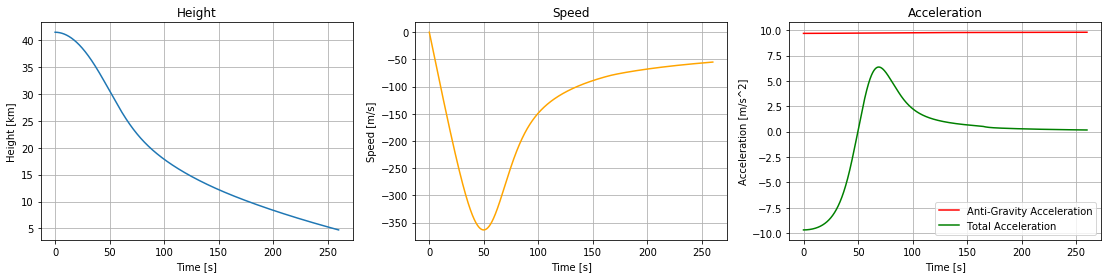

In [32]:
plt.figure(figsize=(19,4))
plt.subplot(131)
plt.plot(time, pos/1000)
plt.xlabel("Time [s]")
plt.ylabel("Height [km]")
plt.title("Height")
plt.grid()

plt.subplot(132)
plt.plot(time, vel, color="orange")
plt.xlabel("Time [s]")
plt.ylabel("Speed [m/s]")
plt.title("Speed")
plt.grid()

plt.subplot(133)
plt.plot(time, grv, color="red", label="Anti-Gravity Acceleration")
plt.plot(time, acc, color="green", label="Total Acceleration")
plt.xlabel("Time [s]")
plt.ylabel("Acceleration [m/s^2]")
plt.title("Acceleration")
plt.grid()
plt.legend()

plt.show()

We observe that anti-gravity stays almost constant through the entire fall, reducing more rapidly towards the end as you rapidly gain more distance from the Earth. Towards the end of the fall into space, anti-gravity is virtually the only contrubutor to the acceleration, as there is no longer a lot of atmosphere to slow you down. The acceleration due to drag has a lot more going on though, it quickly tries to balance out anti-gravity to keep the velocity constant, but then gradually becomes weaker as the atmosphere becomes thinner. We will take a closer look at how this happens in the next section.

We see that you quickly reach a velocity of about 150m/s before the air resistance lowers the acceleration greatly, making the velocity increase very slowly instead. At about the two minute mark the air isn't dense enough to slow you down as much anymore, which makes the speed increase rapidly again.

Height increases very linearly at first, due to the speed being relatively constant. At around two minutes the height starts rising much like a parabola though, due to the fact that as the speed increases the height starts increasing much more.

### Analyzing Acceleration due to Drag

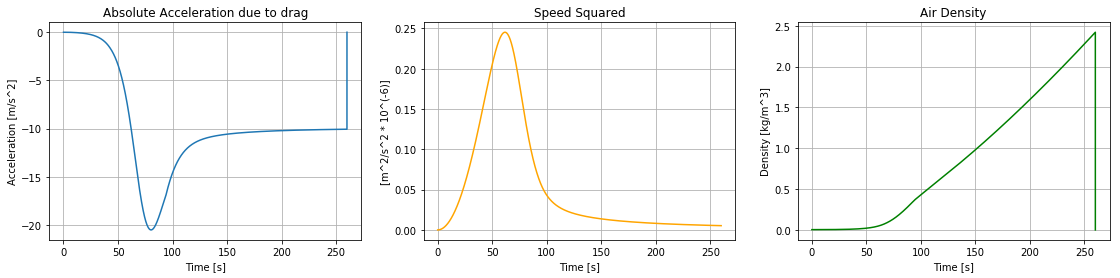

In [12]:
plt.figure(figsize=(19,4))
plt.subplot(131)
plt.plot(time, -drg)
plt.xlabel("Time [s]")
plt.ylabel("Acceleration [m/s^2]")
plt.title("Absolute Acceleration due to drag")
plt.grid()

plt.subplot(132)
plt.plot(time, velsq/1000000, color="orange")
plt.xlabel("Time [s]")
plt.ylabel("[m^2/s^2 * 10^(-6)]")
plt.title("Speed Squared")
plt.grid()

plt.subplot(133)
plt.plot(time, dns, color="green")
plt.xlabel("Time [s]")
plt.ylabel("Density [kg/m^3]")
plt.title("Air Density")
plt.grid()

plt.show()

Acceleration due to drag starts at 0, due to you starting with no velocity, and ends at 0, due to the lack of air in the upper atmosphere.

The speed squared goes from 0 to 1.75 million $m^2/s^2$, while the air density goes from 1.2 to 0 $kg/m^3$.

Despite these three properties being very different in how and why they change, they fit together beautifully to give the fall a very gradual change in acceleration. This gradual change is no accident though, as it comes from the same type of mechanisms that cause things falling normally to reach a constant velocity, their terminal velocity.

In more familiar models for a fall, gravity and air density are both constant. This means that gravity will stay the same, increasing the speed of the falling object while air resistance tries to slow it down. At a certain point though, the object will reach a speed high enough that drag will equal gravity, and the object will from then on keep a constant velocity, as gravity and drag cancel eachother out.

In the first 25 seconds of the fall, you can see something very similar happening. While gravity is almost constant, drag is catching up, as the speed and therefore drag is increasing rapidly. But there is no equilibrium, anti-gravity keeps winning out as drag instead starts decreasing due to the fall in air density. From here, the drag force only becomes weaker, as the air density is decreasing rapidly. It doesen't fall as rapidly as air density does though, as the speed squared is keeping the rapid air density decrease in check, resulting in a more delayed drop.

### The time it takes to fall into space

We can search through the different heights to find the time it takes to reach 100km. We do this by looping through our results until the height is above 100km, and then extracting the current time.

In [13]:
for i in range(len(pos)):
    if pos[i] >= 100000: #If your height reaches 100km
        print(time[i])   #we print the current time
        break            #and stop searching by breaking the loop

We find that it takes 249,5 seconds to fall into space!

During these few minutes you would experience a gradual decrease in temperature, followed by a rise in temperature followed by a sudden drop in temperature again. In the meantime you would also quickly get some serious trouble breathing. Beyond the limit we call space, the atmospheric temperature would actually start increasing again, as the Sun is directly heating the air molecules. There wouldn't be enough air to be able to heat you up though, but you do have the Sun which would give you a great tan and some major burns, on the side of you which isn't being turned into a popsicle.

After you have reached space, you are officially an astronaut according to the <a href="https://www.merriam-webster.com/dictionary/astronaut">Marriam-Webester dictionary</a>, which defines an astronaut as "a person who travels beyond the earth's atmosphere", so congrats!

## Summary and Conclusion

We found that it takes 249,5 seconds to fall into space. At the start of the fall, anti-gravity would quickly increase your speed, but then drag will kick in and make the speed stay nearly constant. It won't take long until the air is too thin to slow you down though, resulting in another big speed increase, continuing until you reach the edge of space.

The model for air resistance we used is a very simplified model, so these results probably won't hold up well to reality. However, the interacton of height, air density, velocity and air resistance that this model offers shows some interesting properties of free fall in the atmosphere that have real world implications.

## Sources and Inspiration

Explanations of the various layers of the atmosphere, and the change in temperature, pressure and density
https://en.wikibooks.org/wiki/High_School_Earth_Science/Atmospheric_Layers    
http://www.atmo.arizona.edu/students/courselinks/fall10/nats101s12/ritchie/

The Karman Line - https://books.google.no/books?id=dTwIDun4MroC&pg=PA84&redir_esc=y#v=onepage&q&f=false

Drag - https://en.wikipedia.org/wiki/Drag_(physics)

Drag coefficient - https://en.wikipedia.org/wiki/Drag_coefficient

The US Standard Atmosphere - https://ntrs.nasa.gov/search.jsp?R=19770009539

Geopotential Height - https://en.wikipedia.org/wiki/Geopotential_height

Speed Skydiving - https://en.wikipedia.org/wiki/Speed_skydiving

Drag coefficient approximations(downloads pdf) - https://cnx.org/exports/be308439-f9b1-40e7-b0a6-1631cbc7feaa@8.pdf/drag-forces-8.pdf